In [30]:
from copy import deepcopy
import math
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from citylearn.agents.sac import  SACBasicBatteryRBC as Agent
from citylearn.citylearn import CityLearnEnv
from citylearn.cost_function import CostFunction
from citylearn.utilities import read_json

In [82]:
# constants and variables
TIMESTAMPS = pd.DataFrame(pd.date_range('2016-08-01 00:00:00','2017-07-31 23:00:00',freq='H',tz='America/Los_Angeles'),columns=['timestamp'])
TIMESTAMPS['time_step'] = TIMESTAMPS.index
TIMESTAMPS['hour'] = TIMESTAMPS['timestamp'].dt.hour
TIMESTAMPS['day_of_week'] = TIMESTAMPS['timestamp'].dt.weekday
TIMESTAMPS['month'] = TIMESTAMPS['timestamp'].dt.month
TIMESTAMPS['year'] = TIMESTAMPS['timestamp'].dt.year
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
destination_directory = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/single_building/')
schema_root_directory = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/citylearn_challenge_2022_phase_3/')

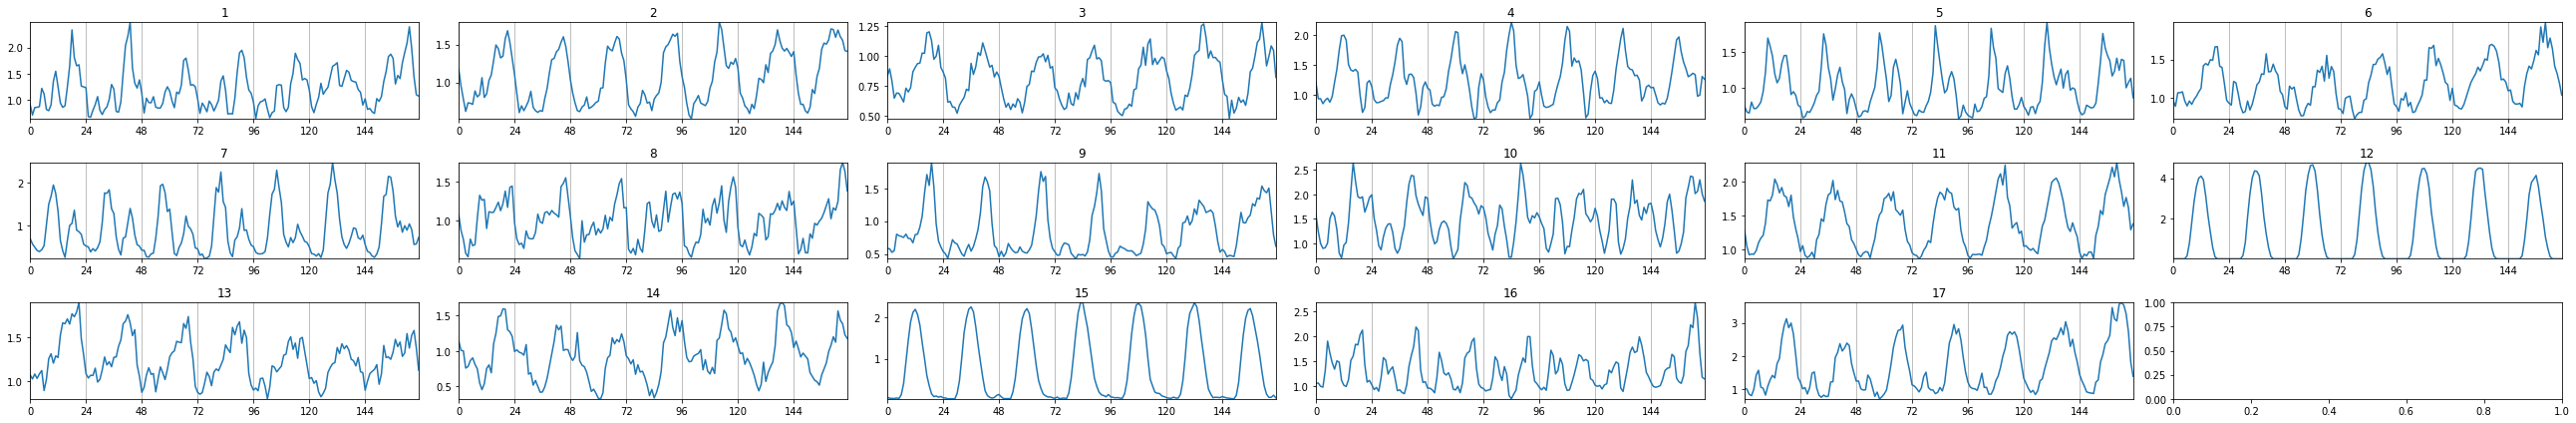

In [88]:
# building data
data_list = []
for f in os.listdir(schema_root_directory):
    if f.startswith('Building_'):
        d = pd.read_csv(os.path.join(schema_root_directory,f))
        d['time_step'] = d.index
        d = d.merge(TIMESTAMPS,on='time_step',how='left')
        d['building'] = int(f.split('.')[0].split('_')[-1])
        data_list.append(d)
    else:
        continue
    
building_data = pd.concat(data_list,ignore_index=True)
building_data = building_data.groupby(['building','day_of_week','hour'])[['Equipment Electric Power [kWh]']].mean().reset_index()
building_count = len(building_data['building'].unique())
column_limit = 6
row_count = math.ceil(building_count/column_limit)
column_count = min(column_limit,building_count)
fig, _ = plt.subplots(row_count,column_count,figsize=(6*column_count,2*row_count))

for ax, (b, d) in zip(fig.axes, building_data.groupby('building')):
    x, y = d.reset_index().index, d['Equipment Electric Power [kWh]']
    ax.plot(x,y)
    ax.set_title(b)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.grid(visible=True,which='major',axis='x')

plt.tight_layout()
plt.show()

In [3]:
# read schema
schema = os.path.join(schema_root_directory, 'schema.json')
schema = read_json(schema)
schema['root_directory'] = schema_root_directory

# use only 1 building
schema['buildings'] = {'Building_1': schema['buildings']['Building_1']}
schema['reward_function']['type'] = 'reward.RampingReward'
active_observations = ['hour','direct_solar_irradiance_predicted_6h','non_shiftable_load','solar_generation','electrical_storage_soc']

for o in schema['observations']:
    schema['observations'][o]['active'] = True if o in active_observations else False

# initialize environment
env = CityLearnEnv(schema)
env.central_agent = False

# define number of episodes
episodes = 5

# define agent attributes (these hyperparameters are arbitrary and should be tuned to maximize performance).
agent_kwargs = {
    "hidden_dimension": [256,256],
    "discount": 0.99,
    "tau": 0.05,
    "lr": 5e-05,
    "batch_size": 256,
    "replay_buffer_capacity": 100000.0,
    "start_training_time_step": 1000,
    "end_exploration_time_step": 3000,
    "deterministic_start_time_step": 8760*(episodes - 1),
    "action_scaling_coef": 0.5,
    "reward_scaling": 5.0,
    "update_per_time_step": 2,
    "seed": 0,
    "alpha": 0.8
}

# construct agents.
agents = [Agent(
    action_space=a,
    observation_space=o,
    hour_index=env.buildings[0].active_observations.index('hour'),
    **agent_kwargs
) for a, o in zip(env.action_space, env.observation_space)]

In [4]:
# begin simulation for each episode
for episode in range(episodes):
    # for each episode, first reset environment and get initial observations
    observations = env.reset()

    while not env.done:
        # select actions
        actions = [a.select_actions(o) for a, o in zip(agents, observations)]

        # apply actions to citylearn_env
        next_observations, reward_list, _, _ = env.step(actions)

        # update policy
        for agent, o, a, r, n in zip(agents, observations, actions, reward_list, next_observations):
            if agent.action_dimension > 0:
                agent.add_to_buffer(o, a, r, n, done=env.done)
            else:
                continue

        observations = [o for o in next_observations]

        # print progress
        print(
            f'\rTime step: {env.time_step}/{env.time_steps - 1},'\
                f' Episode: {episode}/{episodes - 1},'\
                    f' Actions: {actions}',
            end=' '*10
        )

    b = env.buildings[0]
    rewards = pd.DataFrame(env.rewards)
    actions = pd.DataFrame(agents[0].actions)
    data = pd.DataFrame({
        'net_electricity_consumption':b.net_electricity_consumption,
        'net_electricity_consumption_emission':b.net_electricity_consumption_emission,
        'net_electricity_consumption_price':b.net_electricity_consumption_price,
        'net_electricity_consumption_without_storage':b.net_electricity_consumption_without_storage,
        'net_electricity_consumption_emission_without_storage':b.net_electricity_consumption_without_storage_emission,
        'net_electricity_consumption_price_without_storage':b.net_electricity_consumption_without_storage_price,
        'net_electricity_consumption_without_storage_and_pv':b.net_electricity_consumption_without_storage_and_pv,
        'electrical_storage_soc':b.electrical_storage.soc,
        'electrical_storage_electricity_consumption':b.electrical_storage.electricity_consumption,
        'action':(actions[0].iloc[-8760:]*b.electrical_storage.capacity).tolist(),
        'reward':rewards[0],
    })
    data['time_step'] = data.index
    data['episode'] = episode
    data = data.merge(TIMESTAMPS, on='time_step', how='left')
    data['month'] = data['timestamp'].dt.month
    data['year'] = data['timestamp'].dt.year
    data.to_csv(os.path.join(destination_directory, f'episode_{episode}.csv'),index=False)

Time step: 8759/8759, Episode: 4/4, Actions: [[-0.07840377]]             

In [25]:
# read all data
data_list = []
filenames = [f for f in os.listdir(destination_directory) if f.startswith('episode')]

for f in filenames:
    d = pd.read_csv(os.path.join(destination_directory,f),parse_dates=['timestamp'])
    data_list.append(d)

data = pd.concat(data_list,ignore_index=True)
data = data[data['episode']<=4].copy()
data = data.sort_values('timestamp')
print(data.columns)

Index(['net_electricity_consumption', 'net_electricity_consumption_emission',
       'net_electricity_consumption_price',
       'net_electricity_consumption_without_storage',
       'net_electricity_consumption_emission_without_storage',
       'net_electricity_consumption_price_without_storage',
       'net_electricity_consumption_without_storage_and_pv',
       'electrical_storage_soc', 'electrical_storage_electricity_consumption',
       'action', 'reward', 'time_step', 'episode', 'timestamp', 'month',
       'year'],
      dtype='object')


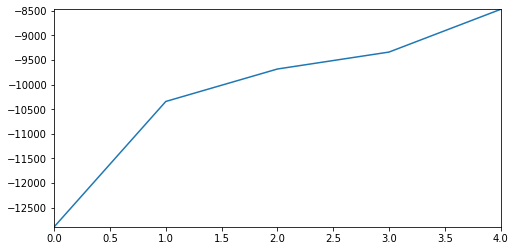

In [26]:
# reward trajectory
plot_data = data.groupby('episode')[['reward']].sum()
x, y = plot_data.index, plot_data['reward']
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(x,y)
plt.show()

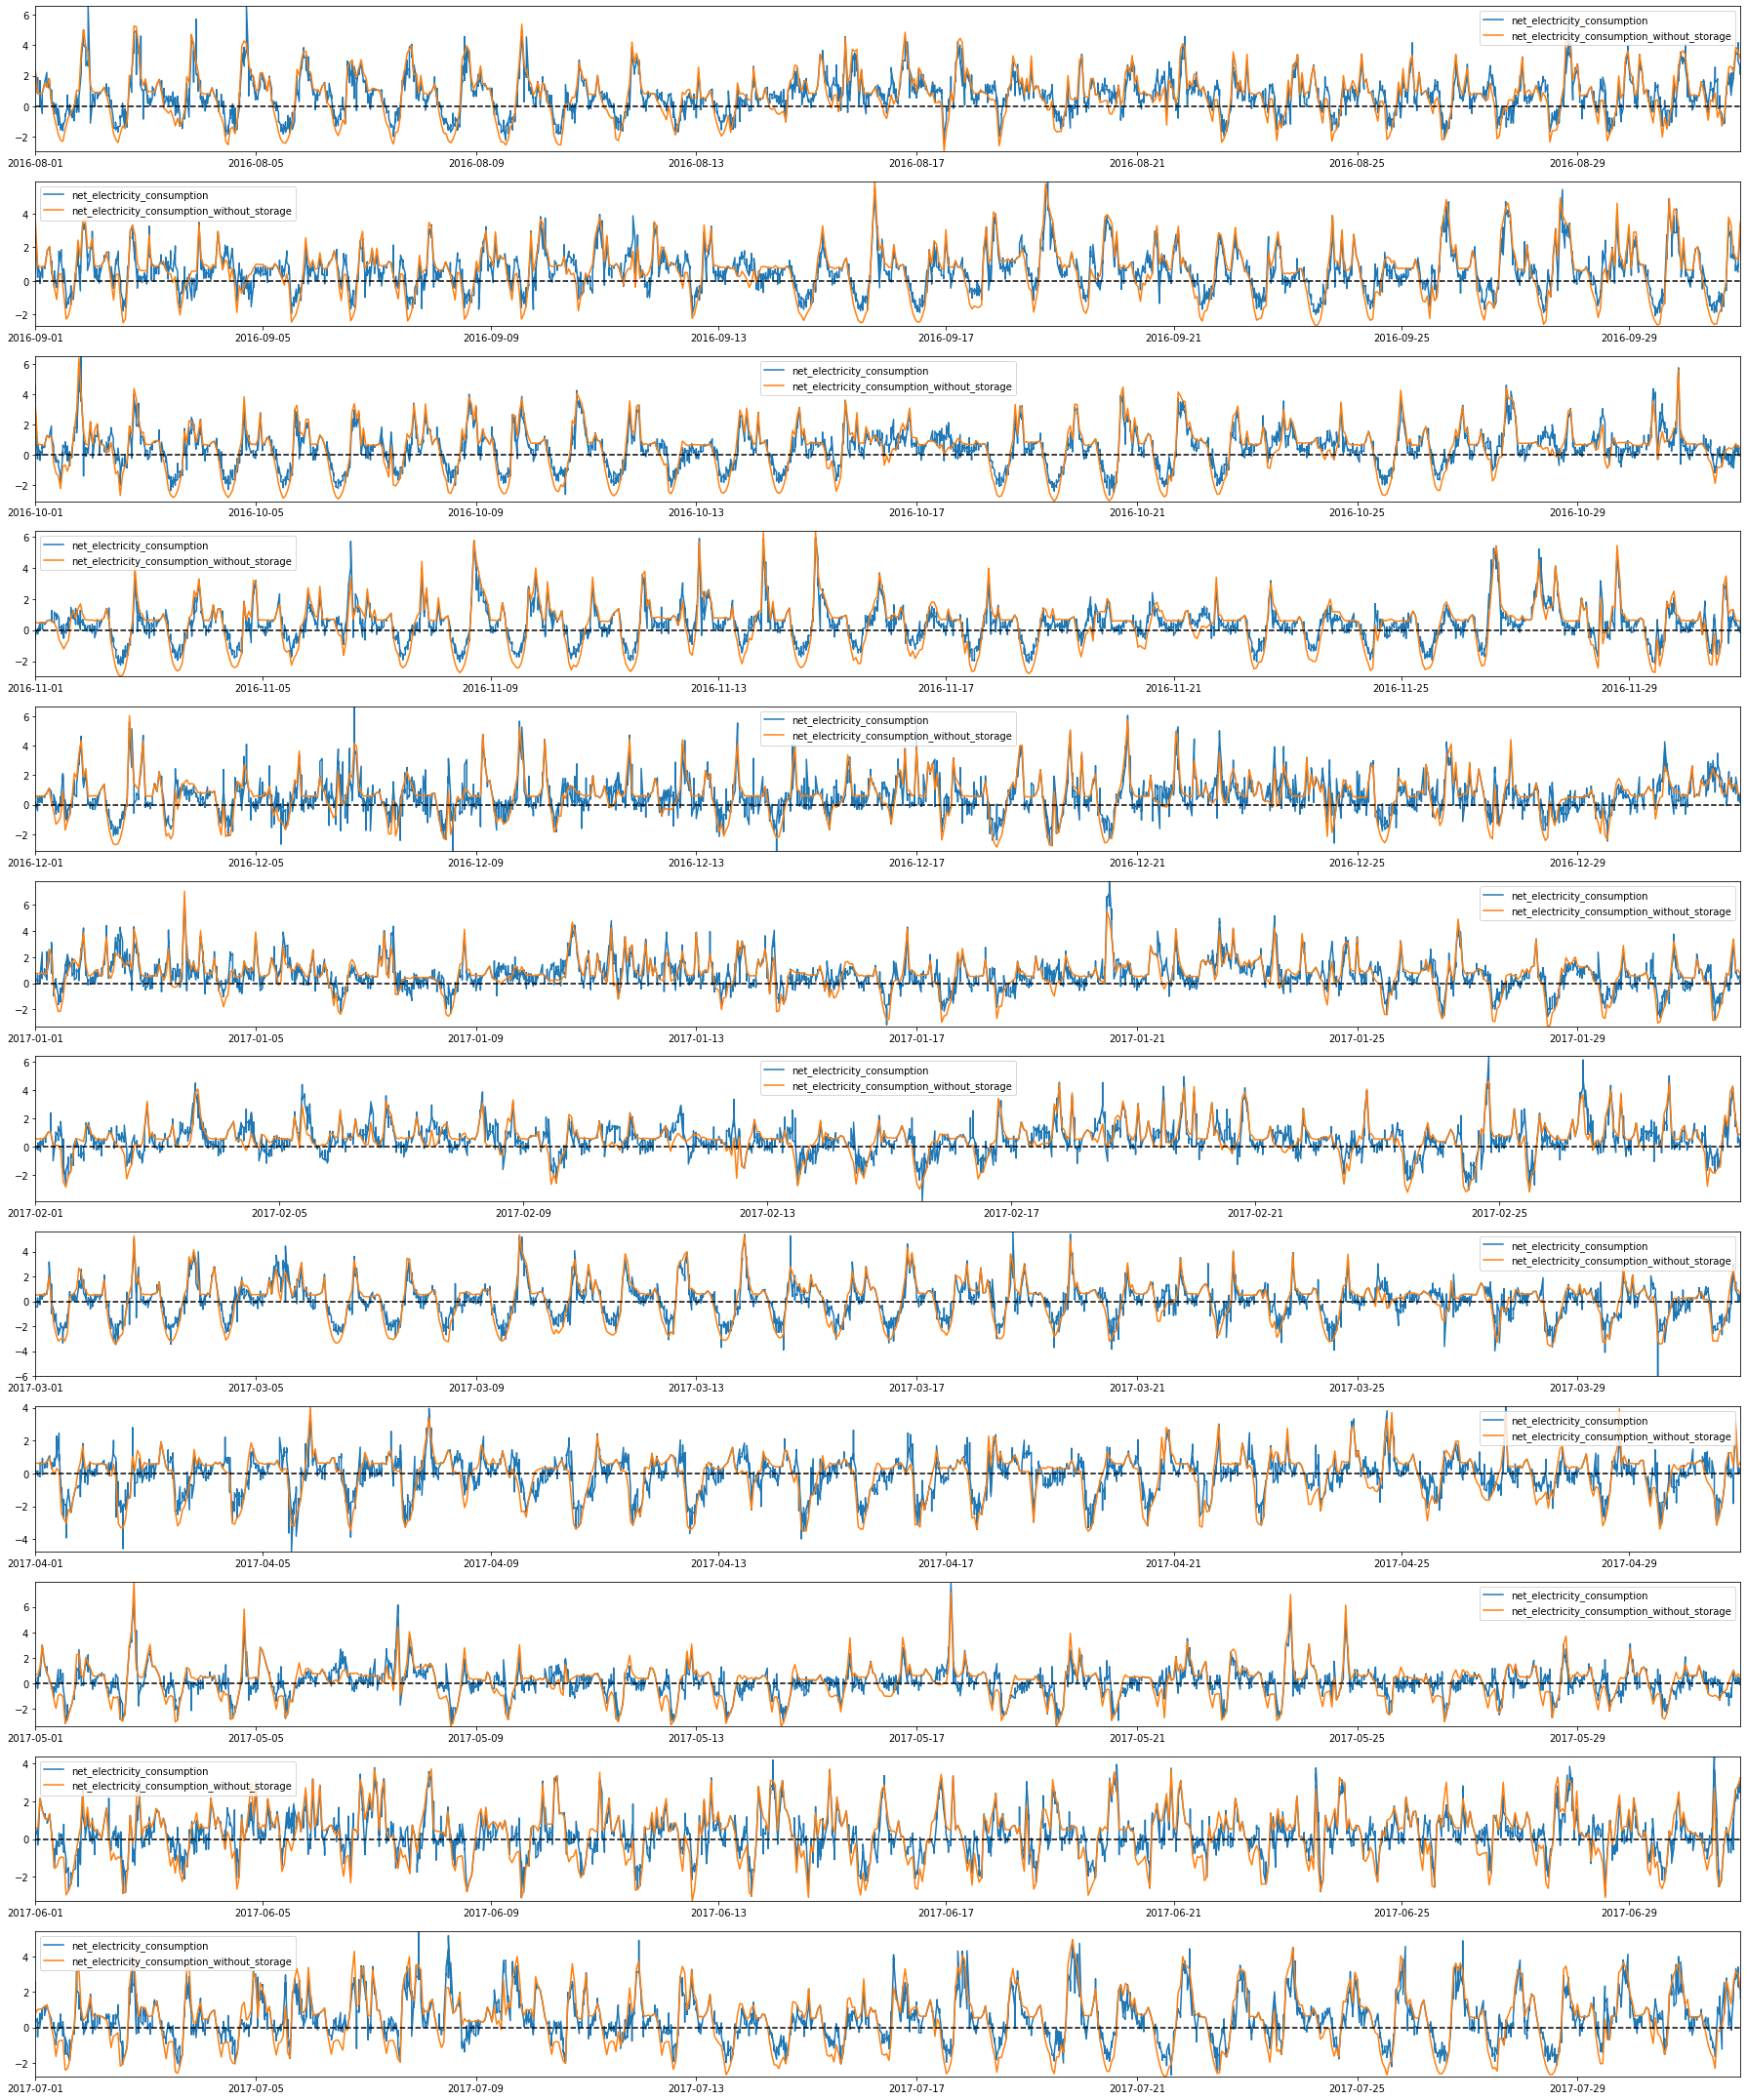

In [28]:
row_count = data.groupby(['year','month']).size().shape[0]
column_count = 1
fig, axs = plt.subplots(row_count, column_count, figsize=(column_count*25, row_count*2.5))

for ax, ((year, month), plot_data) in zip(fig.axes, data.groupby(['year','month'])):
    x = plot_data['timestamp']
    ax.plot(x, plot_data['net_electricity_consumption'],label='net_electricity_consumption')
    ax.plot(x, plot_data['net_electricity_consumption_without_storage'],label='net_electricity_consumption_without_storage')
    # ax.plot(x, plot_data['electrical_storage_electricity_consumption'],label='electrical_storage_electricity_consumption')
    # ax.plot(x, plot_data['action'],label='action')
    # ax.plot(x, plot_data['electrical_storage_soc'],label='electrical_storage_soc')
    ax.axhline(0.0, color='black', linestyle='--')
    ax.legend()

plt.tight_layout()
plt.show()

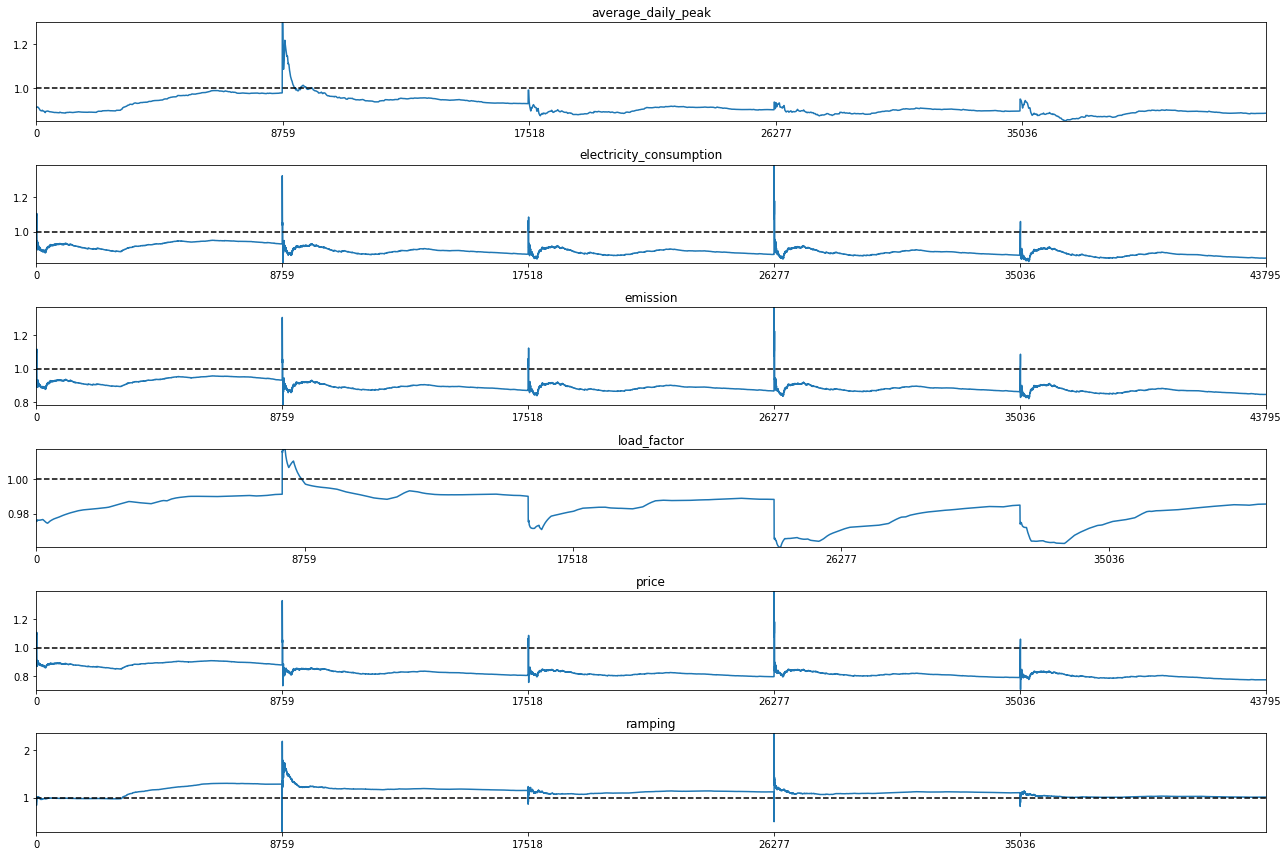

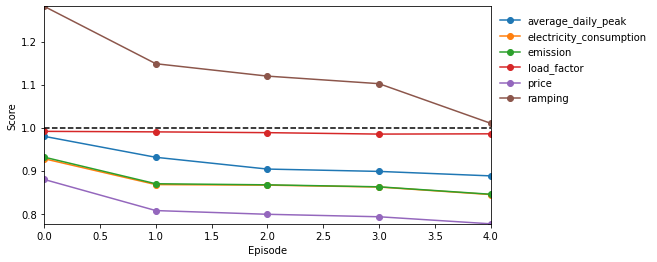

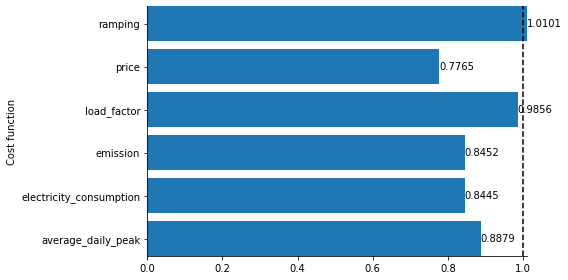

In [29]:
suffixes = ['', '_without_storage']
group_list = []

for suffix in suffixes:
    for episode, group in data.groupby(['episode']):
        group = group.copy()
        column = 'net_electricity_consumption' + suffix
        group['average_daily_peak'] = CostFunction.average_daily_peak(group[column])
        group['load_factor'] = CostFunction.load_factor(group[column])
        group['ramping'] = CostFunction.ramping(group[column])
        group['emission'] = CostFunction.carbon_emissions(group['net_electricity_consumption_emission'+suffix])
        group['price'] = CostFunction.price(group['net_electricity_consumption_price'+suffix])
        group['electricity_consumption'] = CostFunction.net_electricity_consumption(group[column])
        group['storage'] = 'without_storage' if 'without' in suffix else 'with_storage'
        group_list.append(group)

score_data = pd.concat(group_list,ignore_index=True)
del group_list
score_data = score_data.melt(
    id_vars=['episode','time_step','storage'],
    value_vars=['average_daily_peak','load_factor','ramping','emission','price','electricity_consumption'],
    var_name='cost_function'
)
score_data = score_data.pivot_table(index=['episode','time_step','cost_function'],columns='storage',values='value')
score_data = score_data.reset_index()
score_data['score'] = score_data['with_storage']/score_data['without_storage']

# time step evolution
row_count = len(score_data['cost_function'].unique())
column_count = 1
fig, axs = plt.subplots(row_count,column_count,figsize=(column_count*18,row_count*2))

for ax, (cost_function, cost_data) in zip(fig.axes, score_data.groupby(['cost_function'])):
    cost_data = cost_data.sort_values(['episode','time_step'])
    x = cost_data.reset_index().index
    y = cost_data['score']
    ax.plot(x, y)
    ax.axhline(1,color='black',linestyle='--')
    ax.set_title(cost_function)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(cost_data['time_step'].max()))

plt.tight_layout()
plt.show()

# end of episode evolution
row_count = 1
column_count = 1
fig, ax = plt.subplots(row_count,column_count,figsize=(8*column_count,4*row_count))

for cost_function, cost_data in score_data.groupby(['cost_function']):
    cost_data = cost_data[cost_data['time_step']==cost_data['time_step'].max()].copy()
    x, y = cost_data['episode'], cost_data['score']
    ax.plot(x,y,label=cost_function,marker='o')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Score')

ax.axhline(1.0,color='black',linestyle='--')
ax.legend(
    bbox_to_anchor=(1.0,1),
    framealpha=0,
    ncol=1
)
plt.show()

# final score
row_count = 1
column_count = 1
fig, ax = plt.subplots(row_count,column_count,figsize=(column_count*8,row_count*4),sharex=True,sharey=True)
final_data = score_data[
    (score_data['episode']==score_data['episode'].max())
    &(score_data['time_step']==score_data['time_step'].max())
].copy()
y = final_data['score']
x = final_data['cost_function']
rects = ax.barh(x,y)
ax.bar_label(rects,fmt='%.4f',label_type='edge')
ax.axvline(1.0,color='black',linestyle='--')
ax.set_ylabel('Cost function')
ax.set_yticks(x.tolist())
ax.set_yticklabels(x.tolist())
ax.spines[['right','top']].set_visible(False)
plt.tight_layout()
plt.show()

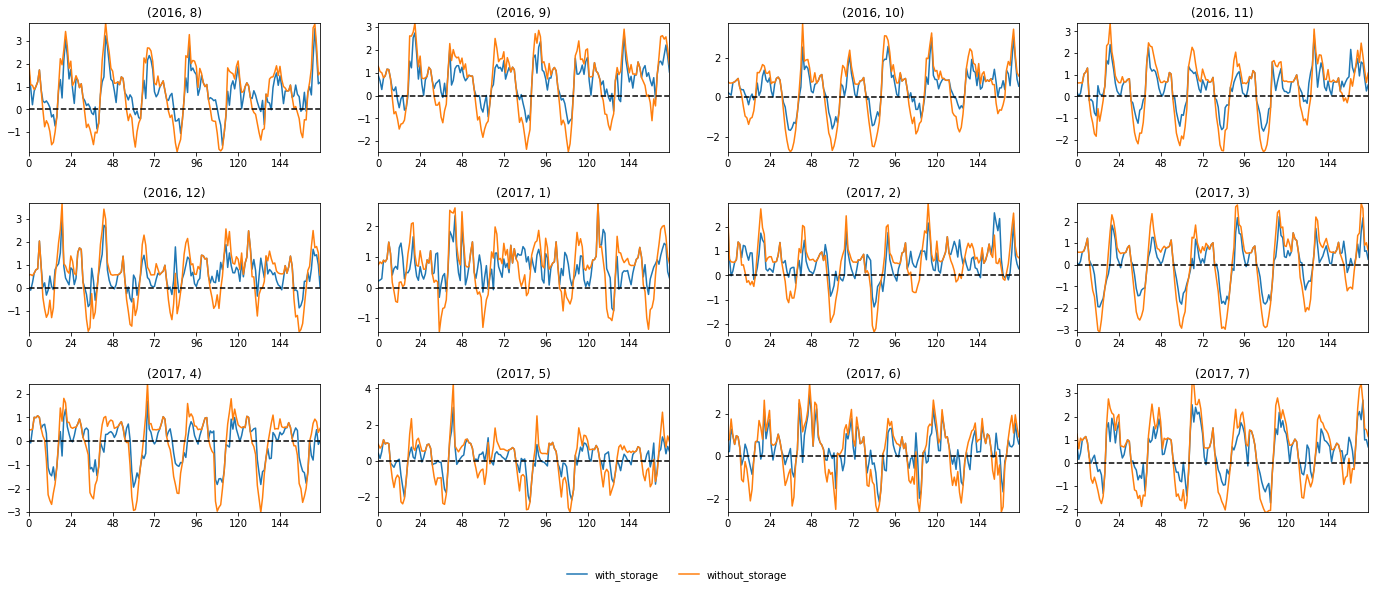

In [50]:
# average weekly profile
plot_data = data[(data['episode']==data['episode'].max())].copy()
plot_data['hour'] = plot_data['timestamp'].dt.hour
plot_data['day_of_week'] = plot_data['timestamp'].dt.weekday
plot_data = plot_data.groupby(['year','month','day_of_week','hour'])[[
    'net_electricity_consumption','net_electricity_consumption_without_storage'
]].mean()
plot_data = plot_data.reset_index()
column_limit = 4
month_count = plot_data.groupby(['month','year']).size().shape[0]
row_count = math.ceil(month_count/column_limit)
column_count = min(month_count,column_limit)
fig, _ = plt.subplots(row_count,column_count,figsize=(column_count*6,row_count*3),gridspec_kw={'hspace':0.4})

for i, (ax, (month, month_data)) in enumerate(zip(fig.axes, plot_data.groupby(['year','month']))):
    x, y1, y2 = month_data.reset_index().index, month_data['net_electricity_consumption'], month_data['net_electricity_consumption_without_storage']
    ax.plot(x, y1, label='with_storage')
    ax.plot(x, y2, label='without_storage')
    ax.axhline(0.0,color='black',linestyle='--')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(24))
    ax.set_title(month)
    if i == 0:
        ax.legend(
            bbox_to_anchor=(0.5,0.05),
            loc='upper center', 
            bbox_transform=fig.transFigure,
            framealpha=0,
            ncol=2
        )
    else:
        pass

plt.show()

In [20]:
plot_data = data[data['episode']==1][['net_electricity_consumption','net_electricity_consumption_without_storage']].copy()
plot_data['net_electricity_consumption_rolling'] = plot_data['net_electricity_consumption'].rolling(
    window=plot_data.shape[0],min_periods=1
).sum()
plot_data['net_electricity_consumption_without_storage_rolling'] = plot_data['net_electricity_consumption_without_storage'].rolling(
    window=plot_data.shape[0],min_periods=1
).sum()
plot_data['ratio'] = plot_data['net_electricity_consumption_rolling']/plot_data['net_electricity_consumption_without_storage_rolling']
plot_data.head()

,net_electricity_consumption,net_electricity_consumption_without_storage,net_electricity_consumption_rolling,net_electricity_consumption_without_storage_rolling,ratio
175200,2.275800,2.275800,2.275800,2.275800,1.000000
175201,1.873798,0.851167,4.149598,3.126967,1.327036
175202,-0.016730,0.834600,4.132869,3.961567,1.043241
175203,0.838167,0.838167,4.971035,4.799733,1.035690
175204,1.478433,1.478433,6.449469,6.278167,1.027285


In [69]:
values = np.array([[1,-2,3],[4,-5,6],[5,-6,7],[5,-6,5]]).clip(min=0)
avg = values.mean(axis=0)
peak = values.max(axis=0)
reward = -peak/avg
reward[np.isnan(reward)] = 0
reward

array([-1.33333333,  0.        , -1.33333333])